# # 🦥 Fine-Tuning Gemma 3 270M for PII Masking
#
# This notebook uses the highly efficient **Unsloth** library and **QLoRA** for fine-tuning the Gemma 3 270M model on the `ai4privacy/pii-masking-400k` dataset using a free Google Colab T4 GPU.
#
# **Workflow:** Evaluate Base Model $\to$ Fine-Tune with PII Data $\to$ Evaluate Fine-Tuned Model
#
# ---

In [1]:
# --- 1. INSTALLATION AND SETUP ---
#
# Install all required libraries including Unsloth and Hugging Face dependencies.

import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Colab specific installation
    import torch; v = re.match(r"[0-9\\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.10.5 requires mistral_common, which is not installed.
unsloth-zoo 2025.10.5 requires msgspec, which is not installed.
unsloth-zoo 2025.10.5 requires tyro, which is not installed.
unsloth-zoo 2025.10.5 requires torchao!=0.14.0,>=0.13.0, but you ha

In [2]:
# --- 2. LOAD MODEL AND ADD LoRA ADAPTERS ---
#
# Load Gemma 3 270M (instruction-tuned) in 4-bit precision for memory efficiency.

from unsloth import FastModel
import torch
from transformers import TextStreamer

# Set global variables
max_seq_length = 2048
model_name = "unsloth/gemma-3-270m-it" # The 270M instruction-tuned model

model, tokenizer = FastModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    # Use load_in_4bit = True for QLoRA, recommended for free T4 Colab.
    # The default template has load_in_4bit = False, but we use 4-bit loading below.
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
)

# Add LoRA adapters
model = FastModel.get_peft_model(
    model,
    r = 128, # Rank: controls expressiveness of the adaptation
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 128, # Scaling factor
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

# Set the correct chat template for Gemma 3
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma3",
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.5: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


model.safetensors:   0%|          | 0.00/393M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth: Making `model.base_model.model.model` require gradients


In [3]:
# --- 3. DATA PREPARATION (PII MASKING) ---
#
# Load the PII dataset and format it as instruction/response pairs.

from datasets import load_dataset
from unsloth.chat_templates import train_on_responses_only

# Load the PII Masking dataset (using a small subset for quick demo)
dataset = load_dataset("ai4privacy/pii-masking-400k", split = "train[:60000]")

# Split the data into a training set and a small evaluation set
dataset = dataset.train_test_split(test_size=10000, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Function to format PII data into Gemma 3's instruction format
def formatting_pii_func(example):
    # The instruction to the model
    instruction = "Mask all Personally Identifiable Information (PII) in the following text with their respective placeholder tags (e.g., [NAME], [EMAIL], [PHONE], etc.). Only return the masked text."

    # Create the conversation template: user message is the source_text, model response is the masked_text
    text = tokenizer.apply_chat_template(
        [
            {"role": "user", "content": f"{instruction}\n\nTEXT:\n{example['source_text']}"},
            {"role": "model", "content": example['masked_text']},
        ],
        tokenize = False,
        add_generation_prompt = False
    ).removeprefix('<bos>')

    return { "text" : text }

# Apply formatting to the datasets
train_dataset = train_dataset.map(formatting_pii_func, batched = False)
eval_dataset = eval_dataset.map(formatting_pii_func, batched = False)

# Select a test sample for pre and post-evaluation
TEST_SAMPLE_INDEX = 42 # Chosen for consistency
TEST_INPUT = eval_dataset[TEST_SAMPLE_INDEX]['source_text']
TEST_EXPECTED = eval_dataset[TEST_SAMPLE_INDEX]['masked_text']

README.md: 0.00B [00:00, ?B/s]

data/train/1en.jsonl:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

data/train/de.jsonl:   0%|          | 0.00/82.7M [00:00<?, ?B/s]

data/train/es.jsonl:   0%|          | 0.00/42.5M [00:00<?, ?B/s]

data/train/fr.jsonl:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

data/train/it.jsonl:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

data/train/nl.jsonl:   0%|          | 0.00/38.4M [00:00<?, ?B/s]

data/validation/1en.jsonl:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

data/validation/de.jsonl:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

data/validation/es.jsonl:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

data/validation/fr.jsonl:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

data/validation/it.jsonl:   0%|          | 0.00/19.8M [00:00<?, ?B/s]

nl.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/325517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/81379 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
# --- 4. PRE-FINE-TUNING EVALUATION ---
#
# Test the base model's ability to mask PII before any fine-tuning.

print("--- Original Input for Pre-Evaluation ---")
print(TEST_INPUT)
print("\n--- Expected Masked Output ---")
print(TEST_EXPECTED)
print("\n--- Base Model Response (Pre-Tuning) ---")

# Format the test message for the base model
messages = [
    {"role": "user", "content": f"Mask all Personally Identifiable Information (PII) in the following text with their respective placeholder tags. Only return the masked text.\n\nTEXT:\n{TEST_INPUT}"},
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True,
).removeprefix('<bos>')

# Generate response
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 125,
    temperature = 0.5,
    top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

--- Original Input for Pre-Evaluation ---
Service Date: March 10th, 1958 <br> Username for Records: SE1958 <br> Client MAC Address: 26:49:58:60:ac:a4 <br> OTP Requirement: 612.3.3. <br> Contact Line: 09-6849-0094 <br> Ethereum Address: 0x1c9ded61ee439a03ba3fa80d0630e382f0923a47 <br> Client Age: 66

--- Expected Masked Output ---
Service Date: [DATEOFBIRTH_1] <br> Username for Records: [USERNAME_1] <br> Client MAC Address: 26:49:58:60:ac:a4 <br> OTP Requirement: 612.3.3. <br> Contact Line: [TELEPHONENUM_1] <br> Ethereum Address: 0x1c9ded61ee439a03ba3fa80d0630e382f0923a47 <br> Client Age: 66

--- Base Model Response (Pre-Tuning) ---
The masked text is:
Service Date: March 10th, 1958 <br> Username for Records: SE1958 <br> Client MAC Address: 26:49:58:60:ac:a4 <br> OTP Requirement: 612.3.3. <br> Contact Line: 09-6849-0094 <br> Ethereum Address: 0x1c9ded61ee439a03ba3fa80d0630e38


In [8]:
# --- 5. TRAIN THE MODEL ---
#
# Set up the SFTTrainer with the evaluation set for logging metrics.

from trl import SFTTrainer, SFTConfig

# Save current GPU memory stats for comparison later
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

# Calculate total training steps based on dataset size, batch size, and epochs
# With 50k training examples and batch size of 8, one epoch is 50000 / 8 = 6250 steps.
# Let's start with 2 epochs for a more substantial training run.
# Total steps = epochs * (dataset_size / batch_size)
num_epochs = 2
total_steps = int(num_epochs * (len(train_dataset) / 8)) # Assuming per_device_train_batch_size = 8

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset, # IMPORTANT: Include the evaluation dataset!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        num_train_epochs = num_epochs, # Set this for the calculated number of epochs
        # max_steps = 100, # Run for 100 steps for a quick demonstration
        learning_rate = 5e-5,
        logging_steps = 100, # Log training and evaluation metrics every 10 steps
        eval_strategy = "steps", # Evaluate on eval_dataset at set interval
        eval_steps = 1000, # Evaluate every 100 steps
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir="outputs",
        report_to = "none",
    ),
)

# Apply response-only masking for higher accuracy in instruction fine-tuning
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

# Start training. Training metrics (Loss, Learning Rate, Epoch) will be logged here.
trainer_stats = trainer.train()

# --- Display Final Training Stats ---
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print("\n--- Training Time and Memory Stats ---")
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

GPU = Tesla T4. Max memory = 14.741 GB.
0.691 GB of memory reserved.
Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/50000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/50000 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/10000 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 2 | Total steps = 12,500
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 30,375,936 of 298,474,112 (10.18% trained)


Step,Training Loss,Validation Loss
1000,0.034000,0.034175
2000,0.028600,0.030355
3000,0.025500,0.026397
4000,0.023500,0.026081
5000,0.022100,0.019759
6000,0.020100,0.022439
7000,0.015400,0.017957
8000,0.015500,0.017588
9000,0.014000,0.016740
10000,0.012700,0.015781


Unsloth: Will smartly offload gradients to save VRAM!

--- Training Time and Memory Stats ---
9917.2422 seconds used for training.
165.29 minutes used for training.
Peak reserved memory = 14.559 GB.
Peak reserved memory for training = 13.868 GB.
Peak reserved memory % of max memory = 98.765 %.
Peak reserved memory for training % of max memory = 94.078 %.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the training and evaluation loss history
train_loss_history = trainer_stats.metrics['train_runtime'] # This is incorrect, need to access the log history
eval_loss_history = trainer_stats.metrics['eval_runtime'] # This is incorrect, need to access the log history

# Correct way to access the log history:
log_history = trainer.state.log_history

train_losses = []
eval_losses = []
steps = []

for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        # Assuming evaluation steps align with training steps logged for loss,
        # or you might need to adjust step tracking if eval_steps is different from logging_steps
        # For simplicity, we'll use the same step count for now, but be aware of this.
        # A more robust approach would be to store eval_steps separately.
        # For now, we'll assume len(train_losses) corresponds to the step for eval_losses
        pass # We will align steps later based on the number of eval_losses

# Align steps for eval_losses. Since eval_strategy is "steps" and eval_steps is 100,
# evaluation occurs every 100 training steps.
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]


plt.figure(figsize=(12, 6))
sns.lineplot(x=steps, y=train_losses, label='Training Loss')
sns.lineplot(x=eval_steps, y=eval_losses, label='Evaluation Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'eval_runtime'

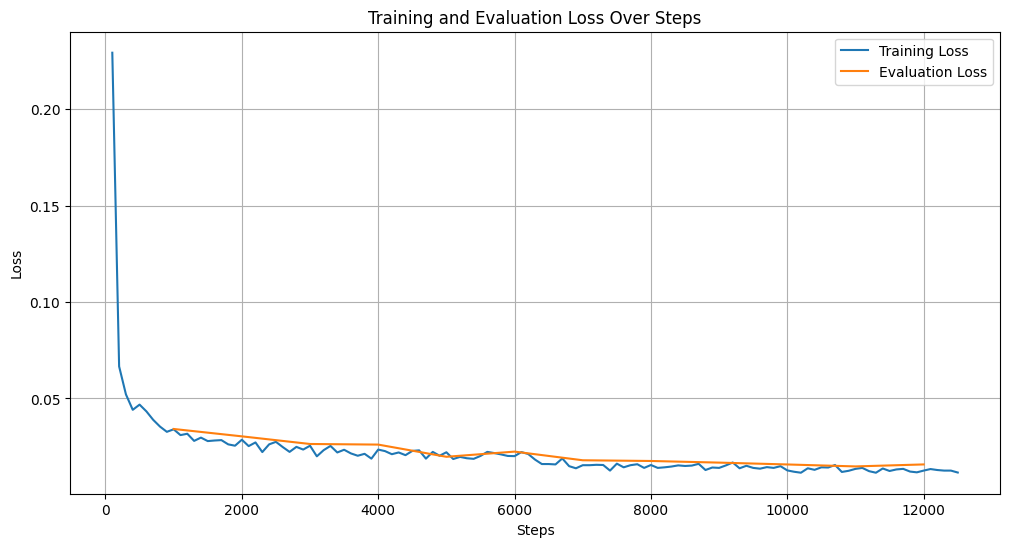

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correct way to access the log history:
log_history = trainer.state.log_history

train_losses = []
eval_losses = []
steps = []

for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        # Assuming evaluation steps align with training steps logged for loss,
        # or you might need to adjust step tracking if eval_steps is different from logging_steps
        # For simplicity, we'll use the same step count for now, but be aware of this.
        # A more robust approach would be to store eval_steps separately.
        # For now, we'll assume len(train_losses) corresponds to the step for eval_losses
        pass # We will align steps later based on the number of eval_losses

# Align steps for eval_losses. Since eval_strategy is "steps" and eval_steps is 100,
# evaluation occurs every 100 training steps.
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]


plt.figure(figsize=(12, 6))
sns.lineplot(x=steps, y=train_losses, label='Training Loss')
sns.lineplot(x=eval_steps, y=eval_losses, label='Evaluation Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 6. POST-FINE-TUNING EVALUATION ---
#
# Test the fine-tuned model against the same input. It should now mask the PII.

print("--- Original Input for Post-Evaluation ---")
print(TEST_INPUT)
print("\n--- Expected Masked Output ---")
print(TEST_EXPECTED)
print("\n--- Fine-Tuned Model Response (Post-Tuning) ---")

# Format the test message again
messages = [
    {"role": "user", "content": f"Mask all Personally Identifiable Information (PII) in the following text with their respective placeholder tags. Only return the masked text.\n\nTEXT:\n My name is Paul Atredis, you can call me on +919694565231, Please contact me."},
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True,
).removeprefix('<bos>')

# Generate response with the fine-tuned model
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 125,
    temperature = 0.5,
    top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

--- Original Input for Post-Evaluation ---
Service Date: March 10th, 1958 <br> Username for Records: SE1958 <br> Client MAC Address: 26:49:58:60:ac:a4 <br> OTP Requirement: 612.3.3. <br> Contact Line: 09-6849-0094 <br> Ethereum Address: 0x1c9ded61ee439a03ba3fa80d0630e382f0923a47 <br> Client Age: 66

--- Expected Masked Output ---
Service Date: [DATEOFBIRTH_1] <br> Username for Records: [USERNAME_1] <br> Client MAC Address: 26:49:58:60:ac:a4 <br> OTP Requirement: 612.3.3. <br> Contact Line: [TELEPHONENUM_1] <br> Ethereum Address: 0x1c9ded61ee439a03ba3fa80d0630e382f0923a47 <br> Client Age: 66

--- Fine-Tuned Model Response (Post-Tuning) ---
My name is [GIVENNAME_1] [SURNAME_1], you can call me on [TELEPHONENUM_1], Please contact me.<end_of_turn>


In [ ]:
# --- Test on a Training Data Sample ---
#
# Test the fine-tuned model on a sample from the training data.

print("--- Original Input from Training Data ---")
# Select a sample from the training dataset
TRAIN_SAMPLE_INDEX = 10 # You can change this index to test different samples
train_input_sample = train_dataset[TRAIN_SAMPLE_INDEX]['source_text']
train_expected_masked_output = train_dataset[TRAIN_SAMPLE_INDEX]['masked_text']

print(train_input_sample)
print("\n--- Expected Masked Output (Training Data) ---")
print(train_expected_masked_output)
print("\n--- Fine-Tuned Model Response (Training Data Test) ---")

# Format the test message for the fine-tuned model
messages = [
    {"role": "user", "content": f"Mask all Personally Identifiable Information (PII) in the following text with their respective placeholder tags. Only return the masked text.\n\nTEXT:\n{train_input_sample}"},
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True,
).removeprefix('<bos>')

# Generate response with the fine-tuned model
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 125,
    temperature = 0.5,
    top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

In [ ]:
#  --- 7. SAVE LoRA ADAPTERS ---
#
# Save the final LoRA adapters locally (or push to Hugging Face).

model.save_pretrained("gemma-3-pii-masker")  # Local saving of LoRA adapters
tokenizer.save_pretrained("gemma-3-pii-masker")

print("\nLoRA adapters saved successfully to 'gemma-3-pii-masker' directory.")

# To push to Hugging Face:
# model.push_to_hub("your_name/gemma-3-pii-masker", token = "...")
# tokenizer.push_to_hub("your_name/gemma-3-pii-masker", token = "...")


LoRA adapters saved successfully to 'gemma-3-pii-masker' directory.
